<a href="https://colab.research.google.com/github/arvindnswamy/RemoteSensing/blob/development/GEE_SatelliteImageAreaPerimeterCannyEdge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import numpy as np
from IPython.display import Image

# Trigger the authentication flow.
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=Z3DrrHnasDSHNtYHyL5HMKngEbnakcVtdpETYQg4Sgo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/2gFPYU4NEpbOxa4nafQs3b5ACIb5HNp1rEcnuDYYK6a4la_Cjwpq_YA

Successfully saved authorization token.


In [2]:
ee.Initialize()

In [3]:
class Time_Lapse_Builder():
    
    
    def __init__(self):
        self.collection = None
        

    def get_collection(self, path_list , row_list , satelite , start_date , end_date , max_cloud_percentage , months):

        # get image collection object
        coll = ee.ImageCollection(satelite)\
            .filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER' , max_cloud_percentage))\
            .filter(ee.Filter.calendarRange(months[0],months[1],'month'))    # just may data
        self.collection = coll
        
        
    def build_movie(self , region , band_list , file_name):
        from ee import batch
        # select the bands we want to video
        bands = self.collection.select(band_list)

        # call the conversion    
        outputVideo = bands.map(lambda x: x.multiply(512).uint8())

        #Export to video.
        out = batch.Export.video.toDrive( outputVideo, description= file_name, dimensions = 720,\
                            framesPerSecond = 2, region= region, maxFrames=10000)

        # process the video
        process = batch.Task.start(out)
        
    def build_movie_url(self , region , band_list):
        bands = self.collection.select(band_list)
        outputVideo = bands.map(lambda x: x.multiply(512).uint8())
        vid = outputVideo.getVideoThumbURL({
              'dimensions': 720,
              'bands': band_list, 
              'framesPerSecond' : 2,
               'region' : ee.Geometry.Polygon([region]) 
        })
    
        return vid

In [4]:
# initialize the class
mc = Time_Lapse_Builder()

# fill in the information
p = [39]                                    # path       
r = [37]                                    # row 
sat = 'LANDSAT/LC08/C01/T1_TOA'             # use this satelite
sd = '2013-05-01'                           # start date
ed = '2020-05-01'                           # end date
cc= 35                                    # max cloud cover percentage
months = [5 , 5]                            # months [start, end]

# collect the images
mc.get_collection(p, r, sat, sd, ed, cc , months)

# this surrounds the box
lake_bounding_box = ([-116.2170533393782,33.578034161036506],\
 [-116.1895875190657,33.03171253668441],\
 [-115.3601197456282,33.045527348747925],\
 [-115.4040650581282,33.64665492287974])

# rgb bands
band_list = ['B4', 'B3', 'B2']

In [ ]:
file_name = 'salton_sea_TimeLapse'
mc.build_movie(lake_bounding_box, band_list , file_name)

In [ ]:
mc.build_movie_url(lake_bounding_box, band_list)

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/videoThumbnails/36c4dc3ea13d77f252c003eda571b6e7-cf9499aceb17302a783e5048436cfd00:getPixels'

In [ ]:
type(mc.get_collection(p, r, sat, sd, ed, cc , months))

NoneType

In [5]:
def get_images(path_list, row_list, satellite, start_date, end_date, max_cloud_percentage):
  coll = ee.ImageCollection(satellite).filterDate(start_date, end_date)\
            .filter(ee.Filter.inList('WRS_PATH', path_list))\
            .filter(ee.Filter.inList('WRS_ROW', row_list))\
            .filter(ee.Filter.lt('CLOUD_COVER', max_cloud_percentage))
  image_ids = list(map(lambda x: x['id'], coll.getInfo()['features']))

  images = list(map(lambda x: ee.Image(x), image_ids))

  return images

In [28]:
# fill in the information
p = [39]                                    # path       
r = [37]                                    # row 
sat = 'LANDSAT/LC08/C01/T1_TOA'             # use this satelite
sd = '2013-05-01'                           # start date
ed = '2020-05-01'                           # end date
cc= 35                                    # max cloud cover percentage

listOfImages = get_images(p, r, sat, sd, ed, cc)

image0 = listOfImages[0]
# this surrounds the box
lake_bounding_box = ([-116.2170533393782,33.578034161036506],\
 [-116.1895875190657,33.03171253668441],\
 [-115.3601197456282,33.045527348747925],\
 [-115.4040650581282,33.64665492287974])

lakeRect = ee.Geometry.Rectangle([-116.2170533393782, 33.03171253668441, -115.4040650581282, 33.578034161036506]); #Created this from lake_bounding_box

parameters = {'min': 0.0,
              'max': 0.3,
              'dimensions': 600,
              'bands': ['B4', 'B3', 'B2']}

Image(url = image0.clip(lakeRect).getThumbUrl(parameters))

In [7]:
image0NDWIB3B6 = image0.normalizedDifference(['B3', 'B6'])
parameters = {'min': -1,
              'max': 1.0,
              'dimensions': 600}
Image(url = image0NDWIB3B6.clip(lakeRect).getThumbUrl(parameters))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


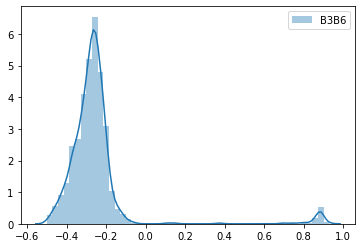

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ndwi_dict_B3B6 = image0NDWIB3B6.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['nd']) 

ndwi_data_B3B6 = ee.List(ndwi_dict_B3B6.get('list')).getInfo()

ax1=plt.gca()
sns.distplot(ndwi_data_B3B6[0], bins=50, ax=ax1, label='B3B6')

ax1.legend(loc='upper right')

In [ ]:
canny = ee.Algorithms.CannyEdgeDetector(image = image0NDWIB3B6, threshold = 2., sigma = 1.) 
#I don't know what I am doing here - I dont understand the values of threshold and sigma - how they affect the final result

In [ ]:
type(canny) #Canny is an image

ee.image.Image

In [ ]:
parameters = {'min': 0,
              'max': 1,
              'dimensions': 600}
Image(url = canny.clip(lakeRect).getThumbUrl(parameters)) #Nice, we can see the outline of the lake. But what about the area and the perimeter?

In [ ]:
canny_dict = canny.sample(numPixels = 1000).reduceColumns(ee.Reducer.toList().repeat(1), ['nd']) 

canny_data = ee.List(canny_dict.get('list')).getInfo()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


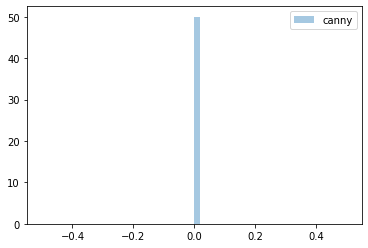

In [ ]:
ax2=plt.gca()
sns.distplot(canny_data, bins=50, ax=ax2, label='canny')

ax2.legend(loc='upper right')

In [ ]:
hough = ee.Algorithms.HoughTransform(canny)

In [ ]:
type(hough)

ee.image.Image

In [ ]:
parameters = {'dimensions': 600}
Image(url = hough.clip(lakeRect).getThumbUrl(parameters))

In [ ]:
import skimage
import cv2 as cv2
from skimage.feature import canny
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi
from skimage.io import imshow

In [ ]:
edges = canny(image0NDWIB3B6) #This is a problem, right? image0NDWIB3B6 is not a 2D array. So, we need to convert  it into a 

ValueError: ignored

In [ ]:
image0NDWIB3B6.bandNames().getInfo()

['nd']

In [ ]:
import numpy as np
ndvi_vals = np.array((ee.Array(image0NDWIB3B6.get('nd').getInfo())))

In [ ]:
ee.Array(image0NDWIB3B6.get('nd').getInfo()).get([5,8])

EEException: ignored

In [ ]:
image0NDWIB3B6.getInfo()

{'bands': [{'crs': 'EPSG:32611',
   'crs_transform': [30, 0, 514185, 0, -30, 3780915],
   'data_type': {'max': 1,
    'min': -1,
    'precision': 'float',
    'type': 'PixelType'},
   'dimensions': [7521, 7311],
   'id': 'nd'}],
 'properties': {'system:footprint': {'coordinates': [[-114.76961921772607,
     32.534658203352706],
    [-114.75491816899816, 32.5863406435207],
    [-114.71491541492514, 32.72683886126911],
    [-114.62704710977094, 33.034005085176915],
    [-114.4124063825575, 33.77702905461259],
    [-114.41234917573499, 33.778928910472864],
    [-115.31954009926606, 33.958503931595594],
    [-116.41890330655002, 34.16625212343165],
    [-116.42134875168904, 34.16626370205588],
    [-116.42199838070515, 34.165198894766746],
    [-116.48531184100317, 33.933083413923804],
    [-116.49956632383845, 33.880078946038736],
    [-116.81952552739395, 32.66397577791603],
    [-116.84576989005632, 32.56151488998202],
    [-116.81640216496797, 32.55594663113574],
    [-115.077449249565

In [ ]:
image0NDWIB3B6.get('nd').getInfo()

In [ ]:
from urllib.request import urlopen
def url_to_image(url):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  resp = urlopen(url)
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  # return the image
  return image

In [ ]:
thumbUrl = image0NDWIB3B6.clip(lakeRect).getThumbURL({'min': 0.0, 'max': 1.0, 'dimensions':600})

In [ ]:
numpImage = url_to_image(thumbUrl) 

In [ ]:
type(numpImage)

numpy.ndarray

In [ ]:
numpImage.shape

(584, 600, 3)

In [ ]:
(numpImage[:,:,0] - numpImage[:,:,2]).min()

0

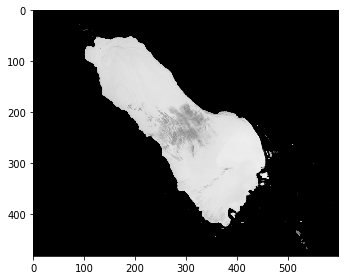

In [ ]:
imshow(numpImage)

In [ ]:
downloadUrl = image0NDWIB3B6.clip(lakeRect).getDownloadURL({'min': 0.0, 'max': 1.0, 'dimensions': 600})

In [ ]:
downloadUrl

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/4ad238137dbd87ffd6e294f0f254b57d-98b334709602af1c7cfebdcf4cb26c69:getPixels'

In [ ]:
numpImageD = url_to_image(downloadUrl) 

In [ ]:
type(numpImageD)

NoneType

In [ ]:
thumbUrl

'https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/e0a09c4172d6f82c58066dbe84c4cef0-ae158faa1b77fedf7dcd254549d80611:getPixels'

In [15]:
latlng = ee.Image.pixelLonLat().addBands(image0NDWIB3B6)
type(latlng)

ee.image.Image

In [16]:
import numpy as np

lakePoint = ee.Geometry.Point((-116.2170533393782 -115.4040650581282)/2, (33.03171253668441+33.578034161036506)/2); #Created this from lake_bounding_box

latlng = latlng.reduceRegion(reducer   = ee.Reducer.toList(), 
                             geometry  = lakePoint.buffer(500), 
                             maxPixels = 1e8, 
                             scale     = 30.0)

lats = np.array((ee.Array(latlng.get("latitude")).getInfo()))    # convert lat lon values to numpy array
lngs = np.array((ee.Array(latlng.get("longitude")).getInfo()))


ndvi_values = np.array((ee.Array(latlng.get("nd")).getInfo()))

In [17]:
type(ndvi_values)

numpy.ndarray

In [18]:
ndvi_values.shape

(1031,)

In [21]:
len(ndvi_values)

1031

In [20]:
lats

array([33.30050267, 33.30050267, 33.30050267, ..., 33.30912649,
       33.30912649, 33.30912649])

In [23]:
image0ZC = image0NDWIB3B6.zeroCrossing()

In [31]:
Image(url = image0ZC.clip(lakeRect).getThumbUrl({'min': 0.0, 'max': 1.0, 'dimensions': 600}) )